In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 5 2024

@author: Yaning
"""
# functions for simulating agent data
# this file address is your own
%run Documents/pyro_models/multi_agent_simulation.py

import math
import os
import numpy as np
# from turtle import position
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.distributions import Normal, Bernoulli, Categorical, Gamma
from tqdm import tqdm
import matplotlib.pyplot as plt
from statistics import mean 
import seaborn as sns
import pandas as pd

In [47]:
# prior mean (mean_u) is between 0 and 10
# prior variance (var_u) is between 1. to 10.
# estimation/likelihood variance is between 1. to 10.

mean_u_list = np.linspace(0., 10., 3)
var_u_list = np.linspace(1., 10., 3)
var_es_list = np.linspace(1., 10., 3)


# initialise trial combinations
repetition = 10
real_delays = [1., 3., 7., 13., 24., 32., 45., 58., 75., 122.]
delays =  [i / 10 for i in real_delays]
SS_values = [3.]
# LL values by percentage of SS
LL_values_p = [1.05, 1.055, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, \
               1.85, 1.9, 2.05, 2.25, 2.55, 2.85, 3.05, 3.45, 3.85]

In [57]:
environment = Environment(SS_values, LL_values_p, delays, repetition)
# run function returns first parameter list then inference list
parameters_list, inference_list = run(mean_u_list, var_u_list, var_es_list, environment)

In [58]:
# SVI model

def model(actions, delays, ss_values, ll_values):
    mean_u_mean_ini = torch.tensor(0.)
    mean_u_var_ini = torch.tensor(1.)
    var_u_alpha_ini =  torch.tensor(1.)
    var_u_beta_ini =  torch.tensor(2.)
    var_es_alpha_ini = torch.tensor(1.)
    var_es_beta_ini = torch.tensor(2.)
    mean_u = pyro.sample("mean_u", Normal(loc=mean_u_mean_ini, scale=mean_u_var_ini))
    log_var_u = pyro.sample("log_var_u", Normal(loc=var_u_alpha_ini, scale = var_u_beta_ini))
    log_var_es = pyro.sample("log_var_es", Normal(loc=var_es_alpha_ini, scale = var_es_beta_ini))
    # var_u = pyro.sample("var_u", Gamma(var_u_alpha_ini, var_u_beta_ini))
    # var_es = pyro.sample("var_es", Gamma(var_es_alpha_ini, var_es_beta_ini))
    # loop over the observed data
    e_vals = []
    for i in range(len(actions)):
        var_u = torch.exp(log_var_u)
        var_es = torch.exp(log_var_es)
        e_vals.append((mean_u*delays[i]*var_es + ll_values[i]*var_u)/(delays[i]*var_es + var_u))
        softmax_args = torch.stack([ss_values[i], e_vals[-1]])
        p = torch.softmax(softmax_args, dim = 0)[0]
        pyro.sample("obs_" + str(i), Bernoulli(probs = p), obs=actions[i])

def guide(actions, delays, ss_values, ll_values):
    mean_u_mean_q = pyro.param("mean_u_mean_q", torch.tensor(0.),
                     constraint=constraints.positive)
    mean_u_var_q = pyro.param("mean_u_var_q", torch.tensor(1.),
                     constraint=constraints.positive)
    var_u_alpha_q = pyro.param("var_u_alpha_q", torch.tensor(2.),
                     constraint=constraints.positive)
    var_u_beta_q = pyro.param("var_u_beta_q", torch.tensor(1.),
                     constraint=constraints.positive)
    var_es_alpha_q = pyro.param("var_es_alpha_q", torch.tensor(1.),
                     constraint=constraints.positive)
    var_es_beta_q = pyro.param("var_es_beta_q", torch.tensor(2.),
                     constraint=constraints.positive)

    # sample from the HalfCauchy prior and normal distributions
    mean_u = pyro.sample("mean_u", Normal(loc=mean_u_mean_q, scale=mean_u_var_q))
    log_var_u = pyro.sample("log_var_u", Normal(var_u_alpha_q, var_u_beta_q))
    log_var_es = pyro.sample("log_var_es", Normal(var_es_alpha_q, var_es_beta_q))
    # var_u = pyro.sample("var_u", Gamma(var_u_alpha_q, var_u_beta_q))
    # var_es = pyro.sample("var_es", Gamma(var_es_alpha_q, var_es_beta_q))

    sample_dict = {'mean_u': mean_u, 'log_var_u': log_var_u, 'log_var_es': log_var_es}

    return sample_dict

# create autoguide (multivariate normal distribution)
auto_g = pyro.infer.autoguide.AutoMultivariateNormal(model)

# # render the graph of the model
# model(actions, delays, ss_values, ll_values)
# pyro.render_model(model=model, model_args=(actions, delays, ss_values, ll_values,),
#                   render_params=True, render_distributions=True,filename="model.pdf")
# pyro.render_model(model=guide, model_args=(actions, delays, ss_values, ll_values,),
#                   render_params=True, render_distributions=True,filename="guide.pdf")


In [59]:
# setup the optimizer
# the learning rate was 0.0005
def inference(actions, delays, ss_values, ll_values, real_params):

    # this is for running the notebook in our testing framework
    smoke_test = ('CI' in os.environ)
    # the step was 2000
    n_steps = 2 if smoke_test else 200

    # assert pyro.__version__.startswith('1.8.6')

    # clear the param store in case we're in a REPL
    pyro.clear_param_store()

    adam_params = {"lr": 0.05, "npart": 15, "betas": (0.90, 0.999)}
    optimizer = Adam(adam_params)
    # setup the inference algorithm
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

    loss = []
    pbar = tqdm(range(n_steps), position = 0)
    # do gradient steps
    for step in pbar:
        loss.append(torch.tensor(svi.step(actions, delays, ss_values, ll_values)))
        pbar.set_description("Mean ELBO %6.2f" % torch.tensor(loss[-20:]).mean())
        if torch.isnan(loss[-1]):
            break
    plt.figure()
    plt.plot(loss)
    plt.xlabel("iter step")
    plt.ylabel("ELBO loss")
    plt.title("ELBO minimization during inference")
    plt.savefig('Documents/pyro_models/plots/parameter' + real_params +'.png')
    plt.show()

    # grab the posterior parameters with own guide
    post_mean_u_mean = pyro.param("mean_u_mean_q").item()
    post_mean_u_var = pyro.param("mean_u_var_q").item()
    post_var_u_alpha = pyro.param("var_u_alpha_q").item()
    post_var_u_beta = pyro.param("var_u_beta_q").item()
    post_var_es_alpha = pyro.param("var_es_alpha_q").item()
    post_var_es_beta = pyro.param("var_es_beta_q").item()

    # # grab posterior from auto guide
    # dict = {}
    # for name, value in pyro.get_param_store().items():
    #     dict[name] = pyro.param(name)

    return [post_mean_u_mean, post_mean_u_var, post_var_u_alpha, \
            post_var_u_beta, post_var_es_alpha, post_var_es_beta]

In [ ]:
posterior_list = []
index_i = -1
for i in inference_list:
    j_list = []
    index_i += 1
    index_j = -1
    for j in i:
        k_list = []
        index_j += 1
        index_k = -1
        for k in j:
            index_k += 1
            k_list.append(inference(torch.tensor(k[0]),
                                    torch.tensor(k[1]),
                                    torch.tensor(k[2]),
                                    torch.tensor(k[3]), 
                                    (str(mean_u_list[index_i]) + '_' +
                                     str(var_u_list[index_j]) + '_' +
                                     str(var_es_list[index_k]))))
        j_list.append(k_list)
    posterior_list.append(j_list)

print(posterior_list)

In [62]:
posterior_list = np.array(posterior_list)

In [66]:
# posterior mean_u
posterior_mean_u = []
posterior_var_u = []
posterior_var_es = []

for i in range(len(mean_u_list)):
    posterior_mean_u.append(mean(np.concatenate(posterior_list[i,:,:,0])))

for i in range(len(var_u_list)):
    posterior_var_u.append(np.exp(mean(np.concatenate(posterior_list[:,i,:,2]))))

for i in range(len(var_es_list)):
    posterior_var_es.append(np.exp(mean(np.concatenate(posterior_list[:,:,i,4]))))

print(posterior_mean_u)
print(posterior_var_u)
print(posterior_var_es)

[0.0, 0.0, 0.0]
[12.921905726580071, 5.431023621676239, 3.037579306244358]
[279.03073771650605, 104.24933355108018, 121.4324059686989]


In [26]:
posterior_list

array([[[[0.        , 0.70440274, 4.09678984, 0.97041285, 0.50605649,
          1.86924553],
         [0.        , 1.05866086, 4.39853239, 0.6521129 , 0.4745456 ,
          1.79442763]],

        [[0.        , 0.5737204 , 0.91127813, 0.69945848, 2.45628524,
          1.01337659],
         [0.        , 1.08353615, 2.82366204, 0.91127765, 0.69895589,
          1.28837276]]],


       [[[0.        , 0.96732432, 0.89416796, 1.02051985, 2.48283839,
          1.26718748],
         [0.        , 1.57763505, 0.87621504, 0.86454022, 2.54496002,
          1.61706579]],

        [[0.        , 0.94623464, 0.87397003, 0.93145931, 2.56352878,
          1.54461658],
         [0.        , 0.63787937, 0.92639786, 0.5951879 , 2.29025698,
          2.42393756]]]])

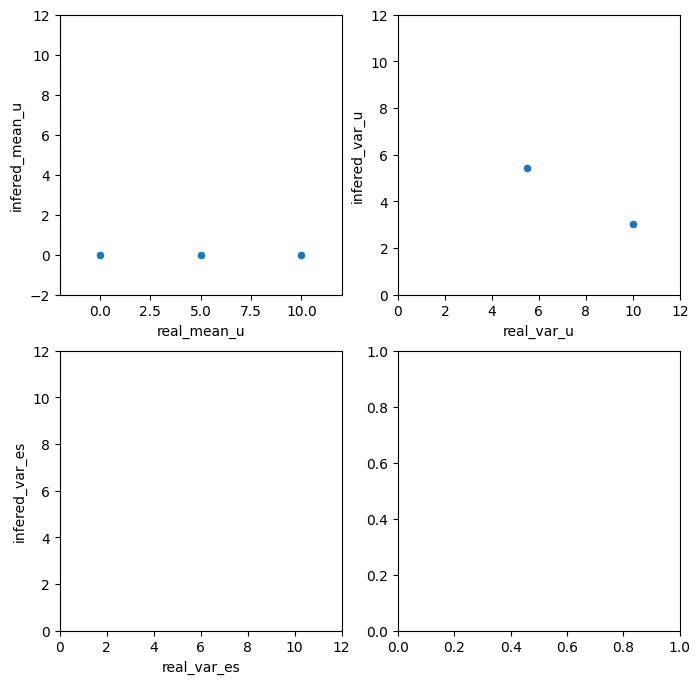

In [67]:
# plot the posterior with simulated data
fig, axs = plt.subplots(2, 2, figsize=(8, 8))


sns.scatterplot(x = mean_u_list, y= posterior_mean_u, ax=axs[0,0])
sns.scatterplot(x = var_u_list, y= posterior_var_u, ax=axs[0,1])
sns.scatterplot(x = var_es_list, y= posterior_var_es, ax=axs[1,0])


# add x labels
axs[0, 0].set_xlabel('real_mean_u')
axs[0, 1].set_xlabel('real_var_u')
axs[1, 0].set_xlabel('real_var_es')
axs[0, 0].set_ylabel('infered_mean_u')
axs[0, 1].set_ylabel('infered_var_u')
axs[1, 0].set_ylabel('infered_var_es')

axs[0,0].set_xlim(-2,12)
axs[0,0].set_ylim(-2,12)
axs[0,1].set_xlim(0,12)
axs[0,1].set_ylim(0,12)
axs[1,0].set_xlim(0,12)
axs[1,0].set_ylim(0,12)

plt.show()